<a href="https://colab.research.google.com/github/JellyX23333/mathForNeuro/blob/main/Week2/Week2Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1

**Linear Algebra II, Matrices**

**[insert your name]**

**Important reminders**: Before starting, click "File -> Save a copy in Drive". Produce a pdf for submission by "File -> Print" and then choose "Save to PDF".

To complete this tutorial, you should have watched Videos 2.1 through 2.5.



**Credits:**
The videos you watched for this week were from 3Blue1Brown. Some elements of this problem set are from or inspired by https://openedx.seas.gwu.edu/courses/course-v1:GW+EngComp4+2019/about. In particular, we are using their `plot_linear_transformation` and `plot_linear_transformations` functions, and the demonstration of the additional transformation of a matrix inverse (end of Exercise 2)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg

# Plotting parameters
matplotlib.rcParams.update({'font.size': 22})

In [7]:
# @title Plotting functions
import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
    fontsize = 4
    fig_scale = 0.75
else:
    fontsize = 5
    fig_scale = 1

grey = '#808080'
gold = '#cab18c'   # x-axis grid
lightblue = '#0096d6'  # y-axis grid
green = '#008367'  # x-axis basis vector
red = '#E31937'    # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
    def wrapper(*args, **kwargs):
        rc('font', family='serif', size=fontsize)
        rc('figure', dpi=200)
        rc('axes', axisbelow=True, titlesize=5)
        rc('lines', linewidth=1)
        func(*args, **kwargs)
    return wrapper

@set_rc
def plot_vector(vectors, tails=None):
    ''' Draw 2d vectors based on the values of the vectors and the position of their tails.

    Parameters
    ----------
    vectors : list.
        List of 2-element array-like structures, each represents a 2d vector.

    tails : list, optional.
        List of 2-element array-like structures, each represents the coordinates of the tail
        of the corresponding vector in vectors. If None (default), all tails are set at the
        origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
        vectors and tails must have the same length.

    Examples
    --------
    >>> v = [(1, 3), (3, 3), (4, 6)]
    >>> plot_vector(v)      # draw 3 vectors with their tails at origin
    >>> t = [numpy.array((2, 2))]
    >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
    >>> t = [[3, 2], [-1, -2], [3, 5]]
    >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails

    '''
    vectors = numpy.array(vectors)
    assert vectors.shape[1] == 2, "Each vector should have 2 elements."
    if tails is not None:
        tails = numpy.array(tails)
        assert tails.shape[1] == 2, "Each tail should have 2 elements."
    else:
        tails = numpy.zeros_like(vectors)

    # tile vectors or tails array if needed
    nvectors = vectors.shape[0]
    ntails = tails.shape[0]
    if nvectors == 1 and ntails > 1:
        vectors = numpy.tile(vectors, (ntails, 1))
    elif ntails == 1 and nvectors > 1:
        tails = numpy.tile(tails, (nvectors, 1))
    else:
        assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

    # calculate xlimit & ylimit
    heads = tails + vectors
    limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
    limit = numpy.ceil(limit * 1.2)   # add some margins

    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue,
                  angles='xy', scale_units='xy', scale=1)
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    axis.set_aspect('equal')

    # if xticks and yticks of grid do not match, choose the finer one
    xticks = axis.get_xticks()
    yticks = axis.get_yticks()
    dx = xticks[1] - xticks[0]
    dy = yticks[1] - yticks[0]
    base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
    loc = ticker.MultipleLocator(base=base)
    axis.xaxis.set_major_locator(loc)
    axis.yaxis.set_major_locator(loc)
    axis.grid(True, **grid_params)

    # show x-y axis in the center, hide frames
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
    """ A helper function to plot the linear transformation defined by a 2x2 matrix.

    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.

    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.

    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.

    title: str, optional.
        Title of the plot.

    """
    assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)
    I = matrix[:,0]
    J = matrix[:,1]
    X = I[0]*X_ + J[0]*Y_
    Y = I[1]*X_ + J[1]*Y_
    origin = numpy.zeros(1)

    # draw grid lines
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
        axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)

    # draw (transformed) unit vectors
    if unit_vector:
        axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
        axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

    # draw optional vectors
    color_cycle = cycle([pink, darkblue, orange, purple, brown])
    if vectors:
        for vector in vectors:
            color = next(color_cycle)
            vector_ = matrix @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

    # draw optional unit circle
    if unit_circle:
        alpha =  numpy.linspace(0, 2*numpy.pi, 41)
        circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
        circle_trans = matrix @ circle
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

    # hide frames, set xlimit & ylimit, set title
    limit = 4
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['left'].set_linewidth(0.3)
    axis.spines['bottom'].set_linewidth(0.3)
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    if title is not None:
        axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a 2x2 matrix using the helper
    function plot_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.

    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.

    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.

    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
    plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')

@set_rc
def plot_linear_transformations(*matrices, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a sequence of n 2x2 matrices using the helper
    function plot_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.

    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 2x2 matrices to visualize. Accept any number of matrices.

    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.

    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.

    """
    nplots = len(matrices) + 1
    nx = 2
    ny = ceil(nplots/nx)
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure, axes = pyplot.subplots(nx, ny, figsize=figsize)

    for i in range(nplots):  # fig_idx
        if i == 0:
            matrix_trans = numpy.identity(2)
            title = 'Before transformation'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'After {} transformation'.format(i)
            else:
                title = 'After {} transformations'.format(i)
        plot_transformation_helper(axes[i//nx, i%nx], matrix_trans, unit_vector=unit_vector, unit_circle=unit_circle, title=title)
    # hide axes of the extra subplot (only when nplots is an odd number)
    if nx*ny > nplots:
        axes[-1,-1].axis('off')


# Exercise 1: Computation corner

For each computation below, please calculate it 1) by-hand and 2) using code. Check that the answers match! For by-hand calculation, please show some work when possible. For example, for matrix multiplication, write out the computation of each element in the resulting matrix so it looks something like this:

$$A = \begin{bmatrix}
5*2+4*1 &  3*5+1*2  \\
0*1+1*2 & 3*2+4*5 \\
\end{bmatrix} $$

Note that these are completely made up numbers for demonstration purposes - the above numbers don't make sense for a matrix multiplication.



## A) Matrix multiplication

Please compute C = AB where $$A = \begin{bmatrix}
5 &  3  \\
0 & 2 \\
\end{bmatrix}, B = \begin{bmatrix}
1 &  5  \\
4 & 3 \\
\end{bmatrix} $$

**Your math answer**
\begin{bmatrix}
    17 & 34 \\
    8 & 6 \\
\end{bmatrix}

In [9]:
# Your code answer
A = np.array([[5, 3], [0, 2]])
B = np.array([[1, 5], [4, 3]])
C = A @ B
print(C)

[[17 34]
 [ 8  6]]


## B) Matrix multiplication

Please compute Z = XY where $$X = \begin{bmatrix}
3 &  2 & 1 \\
1 & 2 & 7 \\
\end{bmatrix}, Y = \begin{bmatrix}
0 &  1  \\
2 & 4 \\
5 & 1 \\
\end{bmatrix} $$

Before computing, figure out what the dimensions of Z will be (no need to explicitly answer this)

**Your math answer**

\begin{bmatrix}
  9 & 12 \\
  39 & 16\\
\end{bmatrix}

In [11]:
X = np.array([[3, 2, 1],[1, 2,7]])
Y = np.array([[0, 1], [2, 4], [5, 1]])
Z = X @ Y
print(Z)

[[ 9 12]
 [39 16]]


## C) (Optional) Transpose

**Please come back to this problem if you complete the rest of the tutorial during class time.**

The **tranpose** of a matrix flips a matrix over its diagonal, changing the rows to columns and the columns to rows. We denote the transpose of matrix X with $X^T$. In numpy, we can get the transpose of an array X with `X.T`.

First, write out the transpose of X from part B yourself and then produce it using code.


**Your math answer**

In [5]:
# Your code answer

You could not compute $X^TY$ - why not?

**Your text answer**

# Exercise 2: Thinking about transformations

In the video *Linear transformations and matrices*, you learned that a matrix corresponding to a rotation by 90 degrees is $$X = \begin{bmatrix}
0 &  -1  \\
1 & 0 \\
\end{bmatrix}$$ You also saw that one matrix for which the transformation is horizontal shear is $$X = \begin{bmatrix}
1 &  1  \\
0 & 1 \\
\end{bmatrix}$$

In this exercise, we will think about some other types of transformations. We will use  `plot_linear_transformation(X)` to see the grid before and after the transformation corresponding to matrix $X$.


**Remember to think about where your basis vectors should end up! Then your matrix consists of the transformed basis vectors. Drawing out what you want to happen can help**

## A) Reflection across x2 axis

Come up with a matrix $A$ for which the corresponding linear transformation is reflection through the $x_2$ axis (flipping across the $x_2$ axis). For example, $\bar{x} = \begin{bmatrix}
1 \\
5  \\
\end{bmatrix}$ should become $\bar{b} = \begin{bmatrix}
-1 \\
5  \\
\end{bmatrix}$ when multiplied with $A$.





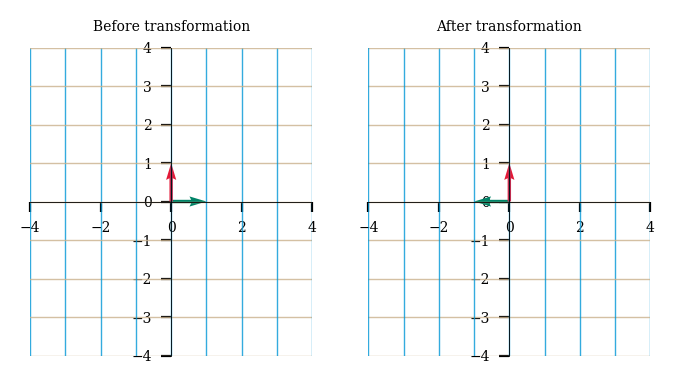

In [12]:
A = np.array([[-1, 0],[0, 1]])
plot_linear_transformation(A)

Would you expect the determinant of A to be positive or negative? Why? Would you expect the absolute value of the determinant to be greater than 1, less than 1, or equal to 1. Why?

**Your text answer**
The determinant is negative as for flip of area.

THe determinant is equal to 1 as the area formed by basis is equal.

## B) Projection onto x1

Come up with a matrix $A$ for which the corresponding linear transformation is projecting onto the $x_1$ axis. For example, $\bar{x} = \begin{bmatrix}
1 \\
5  \\
\end{bmatrix}$ should become $\bar{b} = \begin{bmatrix}
1 \\
0  \\
\end{bmatrix}$ when multiplied with $A$.


In [ ]:
A = ...
plot_linear_transformation(A)

Would you expect the determinant of A to be positive or negative? Why? Would you expect the absolute value of the determinant to be greater than 1, less than 1, or equal to 1. Why?

**Your text answer**

## C) (Optional) Figuring out the transformation from a matrix

**Please come back to this problem if you complete the rest of the tutorial during class time.**

$$A = \begin{bmatrix}
3 &  1  \\
0 & 3 \\
\end{bmatrix}$$

Try to answer the below questions without looking at the plot of the transformation, but feel free to do so if you get stuck

i) This matrix is a composition of two basic transformations, where possible basic transformations are reflection, contraction, expansion, horizontal shear, vertical shear, and projection.  What are the two basic transformations it is a composition of? (Hint: does this matrix look at all like either of the two in the description below Exercise 2?)

ii) Would you expect the determinant of A to be positive or negative? Why? Would you expect the absolute value of the determinant to be greater than 1, less than 1, or equal to 1. Why?

iii) Rewrite A as a matrix multiplication of two matrices where each matrix corresponds to one of the basic transformations.




**Your text answer**

In [ ]:
A = np.array([[3, 1], [0, 3]])
#plot_linear_transformation(A)

## Extra info: Matrix inverse transformation

We know that the inverse of a matrix essentially "undoes" the transformation of the matrix. Let's see this in action. We will plot the transformation of A then the additional transformation of $A^{-1}$ - the resulting plot should look like the original.

In [ ]:
A = np.array([[1,2], [2,1]])
A_inv = np.linalg.inv(M)
plot_linear_transformations(A, A_inv)

# Exercise 3: Encoding model matrices

Let's say we have a population of 3 visual neurons that respond to 3 pixel images. Each neural response is a weighted sum of the pixel image: we used this type of model in Week 1 Part 1 Exercise 2. We will now allow the pixels to have negative values.


We will look at two different populations of 3 neurons with different weights from the pixels: population f and population g. Below, we have the system of linear equations that dictates the neuron models for each population. $x_1$, $x_2$, and $x_3$ correspond to the pixel values. $r_{f1}$, $r_{f2}$, and $r_{f3}$ correspond to the responses of neurons 1, 2, and 3 in population f. $r_{g1}$, $r_{g2}$, and $r_{g3}$ correspond to the responses of neurons 1, 2, and 3 in population g.



Population f:
$$\begin{align}
x_1 + 3x_2 + 4x_3 &= r_{f1} \\
2x_1 + x_2 + 4x_3 &= r_{f2} \\
x_1 + 5x_2 + 6x_3 &= r_{f3} \\
\end{align}$$



Population g:
$$\begin{align}
x_2 + x_3 &= r_{g1} \\
6x_1 + 10x_2 &= r_{g2} \\
3x_1 + 6x_2 + x_3 &= r_{g3} \\
\end{align}$$

## A) Rewriting linear systems of equations to matrix equation

We want to rewrite the above system of equations for each population in the matrix equation $F\bar{x} = \bar{r}_f$ where $\bar{x}$ is the image and $\bar{r}_f$ is the vector of neural responses in population f. What is F?


We will do the same for population g: $G\bar{x} = \bar{r}_g$ where $\bar{r}_g$ is the vector of neural responses in population g. What is G?

**Your math answer**

We started with the linear system of equations view but, as always, we can think about this matrix equation in terms of a linear transformation. In particular matrices F and G are transforming vectors from a "pixel basis", where each element of a vector represents one pixel to a "neural basis" where each element represents the response of one neuron.

## B) Solving a matrix equation

We will now try to solve the matrix equation to find $\bar{x}$ for a given $\bar{r}_f$. What does this correspond to in the neuroscience setting (aka what is $\bar{x}$ here)?

**Your text answer**

Find $\bar{x}$ if $$\bar{r}_f = \begin{bmatrix}
1 \\
1 \\
2 \\
\end{bmatrix}$$


We will use two different coding methods: you will first use `np.linalg.inv`, and then `np.linalg.solve`.

In [ ]:
# Define F
F = ...

# Define r_f
r_f = ...

# Find x using np.linalg.inv
x_using_inv = ...

# Find x using np.linalg.solve
x_using_solve = ...

# Check each method resulted in the same x
if np.all(np.isclose(x_using_inv, x_using_solve)):
  print('Solutions match')
else:
  print('PROBLEM: Solutions do not match!')


## C) Solving another matrix equation

Try to repeat the steps in B for population g where
$$\bar{r}_g = \begin{bmatrix}
1 \\
1 \\
2 \\
\end{bmatrix}$$

What problem do you run into?

In [ ]:
# Define G
G = ...

# Define r_g
r_g = ...

# Find x using np.linalg.inv
x_using_inv = ...

# Find x using np.linalg.solve
x_using_solve = ...

# Check each method resulted in the same x
if np.all(np.isclose(x_using_inv, x_using_solve)):
  print('Solutions match')
else:
  print('PROBLEM: Solutions do not match!')


## D) Calculate the rank of F/G

First think: from the video *Inverse Matrices, column space, and null space*, we know that if a n x n matrix is invertible, the matrix is not "squishing" space: all of $R^n$ can be reached via the transformation. Based on this, what do you expect the ranks of F and G to be based on parts B/C? (no need to explicitly answer, just discuss)


Now compute the rank of each below and see if you were right.

In [ ]:
rank_F = ...
rank_G = ...

print('The rank of F is '+str(rank_F))
print('The rank of G is '+str(rank_G))


## E) Linearly independent or dependent columns

Are the columns of F linearly dependent of independent? How do you know? How about the columns of G? How do you know? (Hint: use the words rank and column space in your answer)

**Your text answer**

## F) Finding the null space

Use `scipy.linalg.null_space` to find the basis of the null spaces for F and G.


In [ ]:
F_null_space = ...
G_null_space = ...

From the above computation, what is the dimension of the null space for F? For G? What does the null space correspond to in our neuroscience setting?

**Your text answer**

## G) Describing the populations of neurons

So what does all this matrix examination tell us about the neural processing in populations f and g? Obviously this is a toy system but let's think about it.

i) What is the dimensionality of the population of neural responses in population f? How about in g?

ii) If we wanted to decode images from the corresponding neural responses, would we always be able to completely recover the image when looking at population f? How about population g? What does this tell us about the information loss of the neural processing?

iii) If the columns of a matrix are linearly dependent, then the rows also are. What does this mean for the neural weights in population g?


**Your text answer**

## Extra info: Invertible matrix theorem

You may have noticed that F and G have a lot of differences in terms of invertibility, the rank, the dimension of the null space, the linear dependence of columns, etc.  There is a theorem that sums up a lot of these concepts: the **invertible matrix theorem**. This theorem essentially sorts square matrices into two types - invertible and not-invertible - and notes a whole bunch of qualities of each type.

Take a look at the below theorem. If you have time and really want to consolidate your knowledge, think through for each statement why they're either all true or all false. A lot of the theorem stems from what you already know as it is based on definitions or basic concepts.  You do not need to memorize this theorem but it is helpful to remember that these two types of matrices exist.


The below is an informal, incomplete encapsulation of the invertible matrix theorem (aka I'm not including every single statement):

### **Invertible matrix theorem**


Let $A$ be a square n x n matrix. The following statements are either all true or all false for this matrix:

a) $A$ is an invertible matrix

b) The equation $A\bar{x} = \bar{b}$ has only the trivial solution (aka only true if $\bar{x} = \bar{0}$).

c) The columns of $A$ form a linearly independent set.

d) The equation $A\bar{x} = \bar{b}$ has at least one solution for each $\bar{b}$ in $R^n$.

e) The columns of A span $R^n$

f) $A^T$ is an invertible matrix

g) The columns of A form a basis of $R^n$

h) Col A (the column space of A) = $R^n$

i) rank A = n

j) Nul A (the null space of A) = {$\bar{0}$}

k) dim Nul A (the dimension of the null space) = 0

l) The determinant of A is not 0



